# **M Anwaar Khan**
# **BS: Data Science**
# **Linkedin:** https://www.linkedin.com/in/anwaar-khan-3b4975218

# **Brain_Tumor_Using_CNN, VGG, ResNet AND Inception**

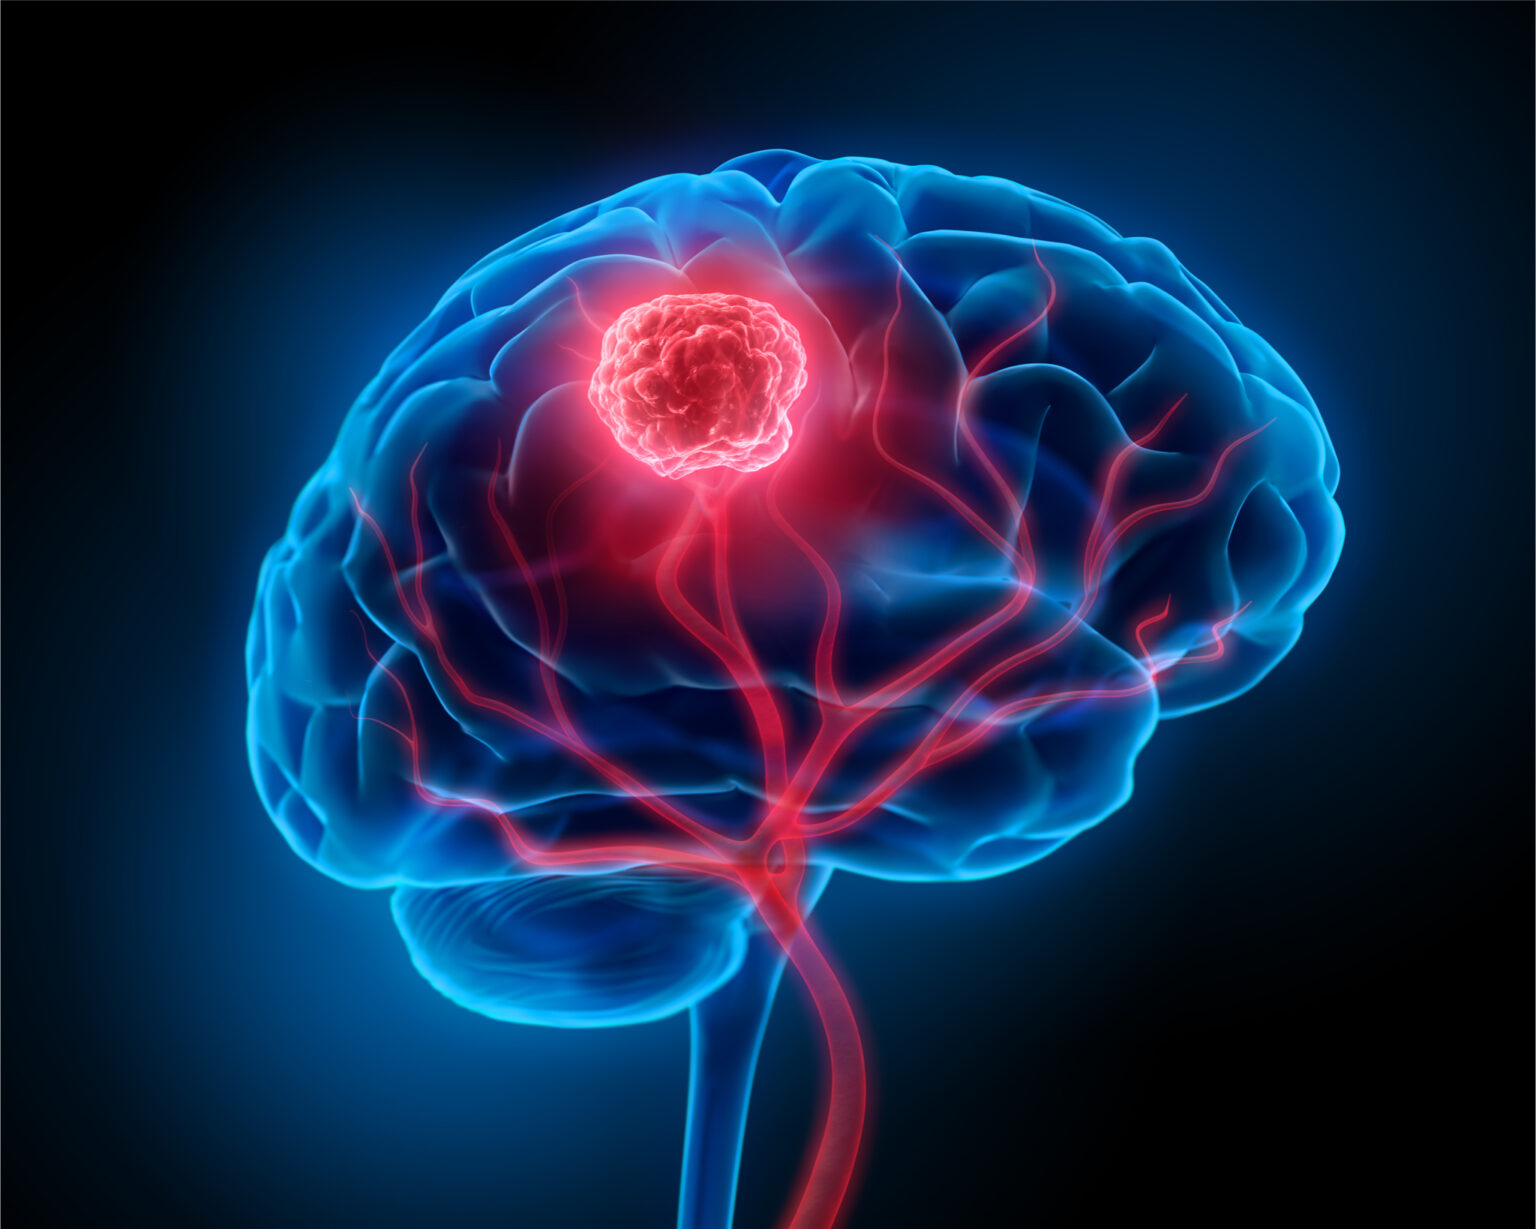

# **Libraries**

In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Corrected import statement
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D

warnings.filterwarnings('ignore')

# **Class for Loading and Splitting Datasets**

In [2]:
class BraintumorDataset:
    def __init__(self, dataDir):
        self.data_dir = dataDir
   
    def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels
  
    def dataFrame(self, files, labels):

        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)
   
    def split_(self):
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)
        strat = df['labels']
        trainData, dummyData = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummyData['labels']
        validData, testData = train_test_split(dummyData, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return trainData, validData, testData

# **Load the Dataset**

In [3]:
df= r'E:\Brain_tumor_dataset'

In [4]:
from sklearn.model_selection import train_test_split

dataSplit = BraintumorDataset(df)
train_data, valid_data, test_data = dataSplit.split_()

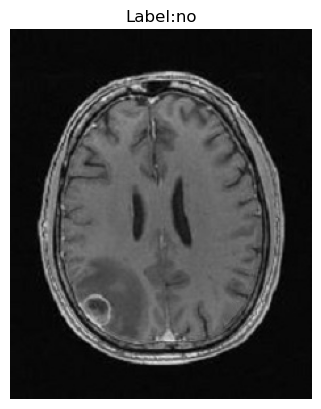

In [5]:
def display_random_image(df):
    random_row = df.sample(1).iloc[0]
    filepath = random_row['filepaths']
    label = random_row['labels']
    
    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(f'Label:{label}')
    plt.axis('off')
    plt.show()

display_random_image(train_data)

# **Preprocessing**

In [6]:
# Define rescaling layer
rescale = tf.keras.layers.Rescaling(1./255)

# Load train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory="E:\Brain_tumor_dataset",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',  # Assuming you have multiple classes
)

# Preprocess train dataset (rescale)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Load validation dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory="E:\Brain_tumor_dataset",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',  # Assuming you have multiple classes
)

# Preprocess validation dataset (rescale)
validation_ds = validation_ds.map(lambda x, y: (rescale(x), y))

# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="E:\Brain_tumor_dataset",  # Specify the directory for the test dataset
    batch_size=32,
    image_size=(256, 256),
    label_mode='categorical',  # Assuming you have multiple classes
    shuffle=False,
)

# Preprocess test dataset (rescale)
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.
Found 253 files belonging to 2 classes.


# **Check Shape After Preprocessing**

In [7]:
# Check the first image shape in the training dataset
print("Shape of the first image in the training dataset:", next(iter(train_ds))[0][0].shape)
# Check the first image shape in the validation dataset
print("Shape of the first image in the validation dataset:", next(iter(validation_ds))[0][0].shape)
# Check the first image shape in the test dataset
print("Shape of the first image in the test dataset:", next(iter(test_ds))[0][0].shape)

Shape of the first image in the training dataset: (256, 256, 3)
Shape of the first image in the validation dataset: (256, 256, 3)
Shape of the first image in the test dataset: (256, 256, 3)


# **Check Pixel Value After Preprocessing**

In [8]:
# Initialize variables to store minimum and maximum pixel values
min_pixel_value = float('inf')
max_pixel_value = float('-inf')

# Iterate through the dataset
for images, _ in train_ds:
    # Compute the minimum and maximum pixel values in the current batch of images
    batch_min = tf.reduce_min(images)
    batch_max = tf.reduce_max(images)
    
    # Update overall minimum and maximum pixel values
    min_pixel_value = tf.minimum(min_pixel_value, batch_min)
    max_pixel_value = tf.maximum(max_pixel_value, batch_max)

# Print the minimum and maximum pixel values
print("Minimum pixel value:", min_pixel_value.numpy())
print("Maximum pixel value:", max_pixel_value.numpy())

Minimum pixel value: 0.0
Maximum pixel value: 1.0


# **Visualization**

In [9]:
def visualize_images(path, target_size=(256, 256), num_images=5):

    # Get a list of image filenames
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image and resize
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# **YES** (Y)

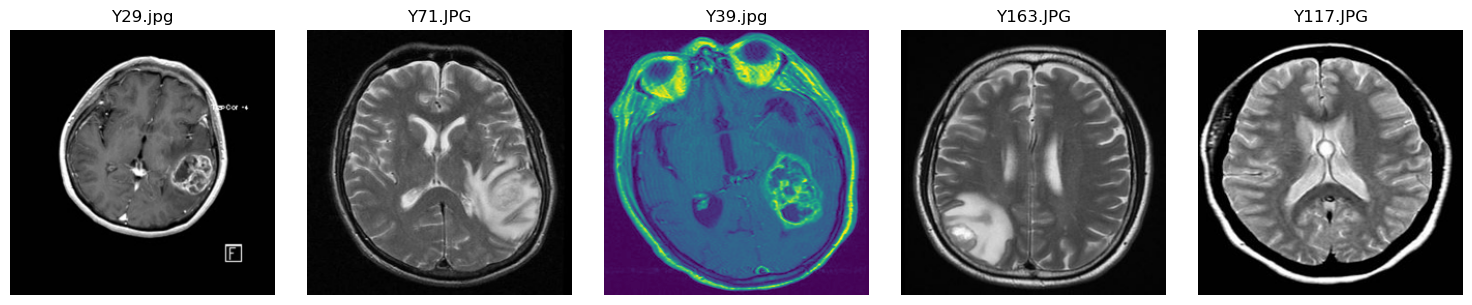

In [10]:
path_to_visualize = "E:/Brain_tumor_dataset/yes"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)


# **NO** (n)

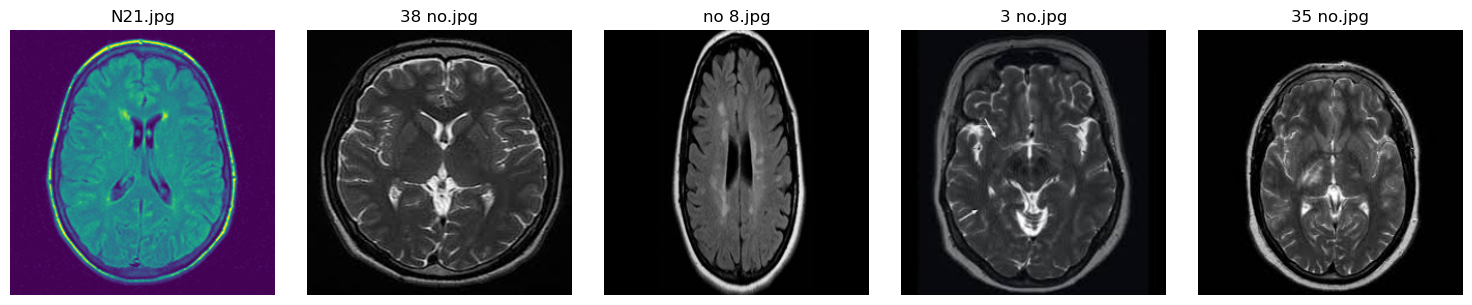

In [11]:
path_to_visualize = "E:/Brain_tumor_dataset/no"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)


# **Build Model**

# **1:- CNN Model**

In [12]:
# Build a basic CNN model

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')])


# comple the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      31,490,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,509,826 (120.20 MB)

 Trainable params: 31,509,826 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

# **Train the CNN Model**

In [13]:
cnn_model.add(Dense(2, activation='softmax'))

model = Sequential([Dense(2, activation='softmax')])  # Output layer with 2 neurons for binary classification

# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
cnn_history = cnn_model.fit(train_ds, validation_data=validation_ds,
                            epochs=7, callbacks=[early_stopping])

Epoch 1/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3664 - loss: 0.9335 - val_accuracy: 0.3600 - val_loss: 0.8461
Epoch 2/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3749 - loss: 0.8344 - val_accuracy: 0.3600 - val_loss: 0.8383
Epoch 3/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4158 - loss: 0.8000 - val_accuracy: 0.3600 - val_loss: 0.8310
Epoch 4/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3970 - loss: 0.8060 - val_accuracy: 0.3600 - val_loss: 0.8235
Epoch 5/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3931 - loss: 0.8020 - val_accuracy: 0.3600 - val_loss: 0.8163
Epoch 6/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4056 - loss: 0.7883 - val_accuracy: 0.3600 - val_loss: 0.8092
Epoch 7/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3978 - loss: 0.7867 - val_accuracy: 0.3600 - val_loss: 0.8022


# **2:- VGG Model**

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Load the VGG16 model pre-trained on ImageNet
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add custom layers on top of VGG16
x = Flatten()(vgg_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(2, activation='softmax')(x)  # Adjust to 2 neurons for binary classification

# Final model
vgg_model_final = Model(inputs=vgg_model.input, outputs=x)

# comple the mode
vgg_model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model_final.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 18,909,378 (72.13 MB)

 Trainable params: 18,909,378 (72.13 MB)

 Non-trainable params: 0 (0.00 B)

# **Training VGG Model**

In [15]:
# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
vgg_history = vgg_model_final.fit(train_ds, validation_data=validation_ds, 
                                  epochs=7, callbacks=[early_stopping])

# Save the model
vgg_model_final.save('vgg_model.h5')


Epoch 1/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 219s 30s/step - accuracy: 0.4382 - loss: 20.2465 - val_accuracy: 0.6400 - val_loss: 1.0088
Epoch 2/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 224s 31s/step - accuracy: 0.5568 - loss: 0.8233 - val_accuracy: 0.6400 - val_loss: 0.6707
Epoch 3/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 214s 30s/step - accuracy: 0.6376 - loss: 0.6687 - val_accuracy: 0.6200 - val_loss: 0.6789
Epoch 4/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 211s 30s/step - accuracy: 0.6699 - loss: 0.6798 - val_accuracy: 0.6400 - val_loss: 0.6474
Epoch 5/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 214s 30s/step - accuracy: 0.5790 - loss: 0.6792 - val_accuracy: 0.6400 - val_loss: 0.6397
Epoch 6/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 580s 91s/step - accuracy: 0.6196 - loss: 0.6443 - val_accuracy: 0.6400 - val_loss: 0.6500
Epoch 7/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 217s 30s/step - accuracy: 0.5684 - loss: 0.6795 - val_accuracy: 0.7400 - val_loss: 0.6878


# **3:- ResNet Model**

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# Load the ResNet50 model pre-trained on ImageNet
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add custom layers on top of ResNet50
x = Flatten()(resnet_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

resnet_model_final = Model(inputs=resnet_model.input, outputs=x)

resnet_model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model_final.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 262, 262, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 128, 128, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 128, 128, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 128, 128, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 130, 130, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 64, 64, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 64, 64, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 64, 64, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 40,365,314 (153.98 MB)

 Trainable params: 40,312,194 (153.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

# **Training ResNet Model**

In [17]:
# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the mode
resnet_history = resnet_model_final.fit(train_ds, validation_data=validation_ds, 
                                  epochs=7, callbacks=[early_stopping])


Epoch 1/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 140s 13s/step - accuracy: 0.5571 - loss: 21.7282 - val_accuracy: 0.4400 - val_loss: 57.4823
Epoch 2/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 85s 12s/step - accuracy: 0.8074 - loss: 1.4840 - val_accuracy: 0.6400 - val_loss: 103.1220
Epoch 3/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 97s 14s/step - accuracy: 0.8435 - loss: 0.3843 - val_accuracy: 0.6400 - val_loss: 409.5411
Epoch 4/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 97s 14s/step - accuracy: 0.9307 - loss: 0.4762 - val_accuracy: 0.6400 - val_loss: 92.4879
Epoch 5/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 99s 14s/step - accuracy: 0.9113 - loss: 0.4908 - val_accuracy: 0.6400 - val_loss: 12721647.0000
Epoch 6/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 98s 14s/step - accuracy: 0.9561 - loss: 0.2182 - val_accuracy: 0.6400 - val_loss: 20977700.0000


# **4:- inception Model**

In [18]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# Load the InceptionV3 model pre-trained on ImageNet
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add custom layers on top of InceptionV3
x = Flatten()(inception_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

inception_model_final = Model(inputs=inception_model.input, outputs=x)

inception_model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
inception_model_final.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 127, 127, 32)      │             864 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 127, 127, 32)      │              96 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 127, 127, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 125, 125, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 125, 125, 32)      │              96 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 125, 125, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 125, 125, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 125, 125, 64)      │             192 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 125, 125, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 62, 62, 64)        │               0 │ activation_2[0][0]         │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 62, 62, 80)        │           5,120 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 62, 62, 80)        │             240 │ conv2d_5[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 62, 62, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 60, 60, 192)       │         138,24

 Total params: 31,240,354 (119.17 MB)

 Trainable params: 31,205,922 (119.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

# **Training Inception Model**

In [19]:
# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train 
inception_history = inception_model_final.fit(train_ds, validation_data=validation_ds, 
                                              epochs=7, callbacks=[early_stopping])

Epoch 1/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 196s 10s/step - accuracy: 0.5492 - loss: 17.0250 - val_accuracy: 0.6400 - val_loss: 4.5117
Epoch 2/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 0.6713 - loss: 0.7770 - val_accuracy: 0.3600 - val_loss: 9.7076
Epoch 3/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 0.8031 - loss: 0.5444 - val_accuracy: 0.3600 - val_loss: 42.9427
Epoch 4/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 0.7606 - loss: 0.4323 - val_accuracy: 0.3600 - val_loss: 47.2684
Epoch 5/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 0.8633 - loss: 0.4746 - val_accuracy: 0.3600 - val_loss: 56.8444
Epoch 6/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 0.8726 - loss: 0.2720 - val_accuracy: 0.3600 - val_loss: 18.7166


# **Evaluate the model**

In [20]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = cnn_model.evaluate(test_ds)
print("Test accuracy of CNN Model:", test_accuracy)

print("::::::::::::::::::::::::::::::::::::::::::::::::")
print("::::::::::::::::::::::::::::::::::::::::::::::::")
print("::::::::::::::::::::::::::::::::::::::::::::::::")

# Evaluate the model on the test dataset
test_loss, test_accuracy = vgg_model_final.evaluate(test_ds)
print("Test accuracy of VGG Model:", test_accuracy)

print("::::::::::::::::::::::::::::::::::::::::::::::::")
print("::::::::::::::::::::::::::::::::::::::::::::::::")
print("::::::::::::::::::::::::::::::::::::::::::::::::")

# Evaluate the model on the test dataset
test_loss, test_accuracy = resnet_model_final.evaluate(test_ds)
print("Test accuracy Resnet Model:", test_accuracy)

print("::::::::::::::::::::::::::::::::::::::::::::::::")
print("::::::::::::::::::::::::::::::::::::::::::::::::")
print("::::::::::::::::::::::::::::::::::::::::::::::::")

# Evaluate the model on the test dataset
test_loss, test_accuracy = inception_model_final.evaluate(test_ds)
print("Test accuracy Inception Model:", test_accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.6779 - loss: 0.6336
Test accuracy of CNN Model: 0.38735178112983704
::::::::::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::::::::::
8/8 ━━━━━━━━━━━━━━━━━━━━ 68s 9s/step - accuracy: 0.3221 - loss: 0.9086
Test accuracy of VGG Model: 0.6126482486724854
::::::::::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::::::::::
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.3984 - loss: 55.2558
Test accuracy Resnet Model: 0.45059287548065186
::::::::::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::::::::::
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.3221 - loss: 6.8821
Test accuracy Inception Model: 0.6126482486724854


# **History Plot**

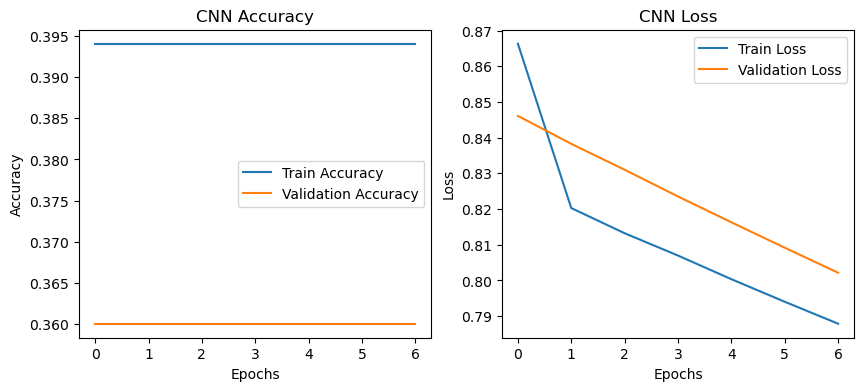

:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


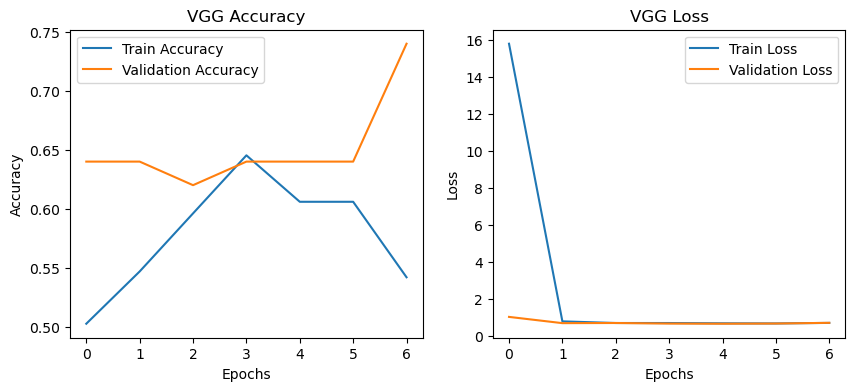

:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


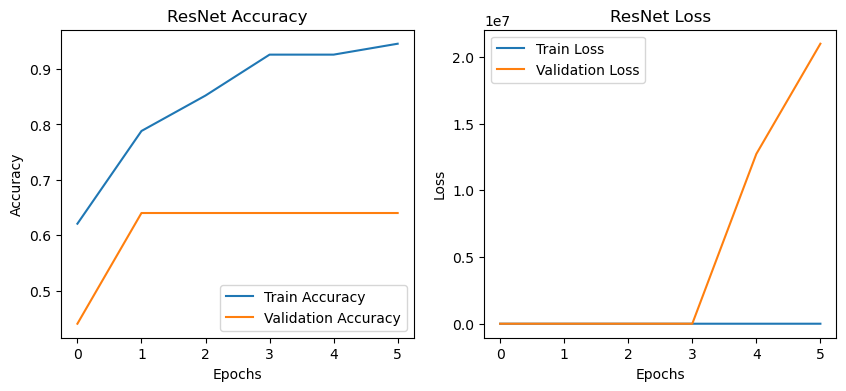

:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


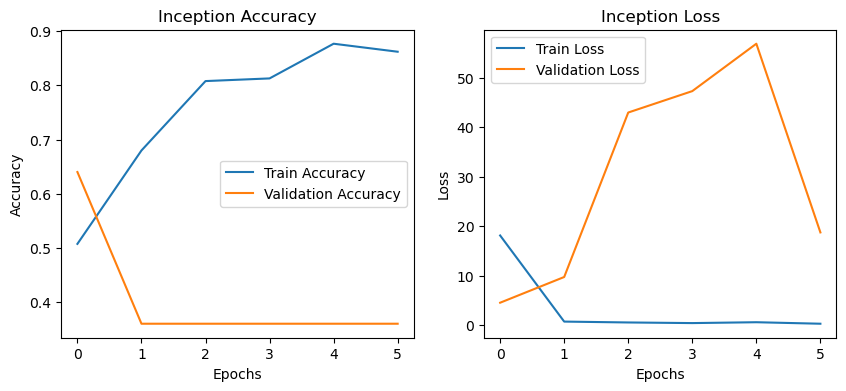

In [21]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(10, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Example for CNN
plot_history(cnn_history, "CNN")
print(":::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::")
# Repeat for other models as needed
plot_history(vgg_history, "VGG")
print(":::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::")
plot_history(resnet_history, "ResNet")
print(":::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::")
plot_history(inception_history, "Inception")